<a href="https://colab.research.google.com/github/Kitenite/reinforcement_learning/blob/main/Bandit_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# !git clone https://github.com/JKCooper2/gym-bandits.git
# !cd gym-bandits && pip install .
# import gym_bandits

Cloning into 'gym-bandits'...
remote: Enumerating objects: 73, done.
remote: Total 73 (delta 0), reused 0 (delta 0), pack-reused 73
Unpacking objects: 100% (73/73), done.
Processing /content/gym-bandits
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for gym-bandits: filename=gym_bandits-0.0.2-py3-none-any.whl size=5194 sha256=a4edef7230b4ab4d95ecdad065bcda32d3bf1e129e3c216829e51d444ec0cd12
  Stored in directory: /root/.cache/pip/wheels/09/de/d5/3573ee26dbd0c8c02e4da1d8ac2b51a2ef2a44ff8170d565d0
Successfully built gym-bandits


#Bandit Env

Adapted from https://github.com/JKCooper2/gym-bandits.git

In [3]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding

class BanditEnv(gym.Env):
    """
    Bandit environment base to allow agents to interact with the class n-armed bandit
    in different variations
    p_dist:
        A list of probabilities of the likelihood that a particular bandit will pay out
    r_dist:
        A list of either rewards (if number) or means and standard deviations (if list)
        of the payout that bandit has
    """
    def __init__(self, p_dist, r_dist):
        if len(p_dist) != len(r_dist):
            raise ValueError("Probability and Reward distribution must be the same length")

        if min(p_dist) < 0 or max(p_dist) > 1:
            raise ValueError("All probabilities must be between 0 and 1")

        for reward in r_dist:
            if isinstance(reward, list) and reward[1] <= 0:
                raise ValueError("Standard deviation in rewards must all be greater than 0")

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.n_bandits = len(p_dist)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.observation_space = spaces.Discrete(1)

        self._seed()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)

        reward = 0
        done = True

        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward = self.r_dist[action]
            else:
                reward = np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        return 0, reward, done, {}

    def reset(self):
        return 0

    def render(self, mode='human', close=False):
        pass


class BanditTwoArmedDeterministicFixed(BanditEnv):
    """Simplest case where one bandit always pays, and the other always doesn't"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[1, 0], r_dist=[1, 1])


class BanditTwoArmedHighLowFixed(BanditEnv):
    """Stochastic version with a large difference between which bandit pays out of two choices"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.8, 0.2], r_dist=[1, 1])


class BanditTwoArmedHighHighFixed(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are good"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.8, 0.9], r_dist=[1, 1])


class BanditTwoArmedLowLowFixed(BanditEnv):
    """Stochastic version with a small difference between which bandit pays where both are bad"""
    def __init__(self):
        BanditEnv.__init__(self, p_dist=[0.1, 0.2], r_dist=[1, 1])


class BanditTenArmedRandomFixed(BanditEnv):
    """10 armed bandit with random probabilities assigned to payouts"""
    def __init__(self, bandits=10):
        p_dist = np.random.uniform(size=bandits)
        r_dist = np.full(bandits, 1)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedUniformDistributedReward(BanditEnv):
    """10 armed bandit with that always pays out with a reward selected from a uniform distribution"""
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = np.random.uniform(size=bandits)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedRandomRandom(BanditEnv):
    """10 armed bandit with random probabilities assigned to both payouts and rewards"""
    def __init__(self, bandits=10):
        p_dist = np.random.uniform(size=bandits)
        r_dist = np.random.uniform(size=bandits)
        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)


class BanditTenArmedGaussian(BanditEnv):
    """
    10 armed bandit mentioned on page 30 of Sutton and Barto's
    [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0)
    Actions always pay out
    Mean of payout is pulled from a normal distribution (0, 1) (called q*(a))
    Actual reward is drawn from a normal distribution (q*(a), 1)
    """
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = []

        for _ in range(bandits):
            r_dist.append([np.random.normal(0, 1), 1])

        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)

#Bandit Alg

Displaying a simple e-greedy bandit algorithm (sample average). 
Enhancements needed: Add step-size discount in order to handle nonstationnary rewards.

In [6]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from collections import defaultdict
import random

e: 0.0 	 Total rewards: 556.5443727299837
e: 0.1 	 Total rewards: 1076.718690082444
e: 0.2 	 Total rewards: 955.7122766949304
e: 0.3 	 Total rewards: 812.2481483993986
e: 0.4 	 Total rewards: 709.8612203007428
e: 0.5 	 Total rewards: 571.2341697073275
e: 0.6 	 Total rewards: 354.88632796512786
e: 0.7 	 Total rewards: 322.0033139152303
e: 0.8 	 Total rewards: 154.95337156068766
e: 0.9 	 Total rewards: 48.685240921062814
e: 1.0 	 Total rewards: 62.78234247078158


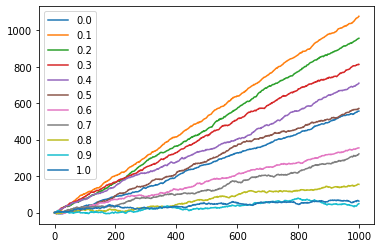

In [88]:
env = gym.make("BanditTenArmedGaussian-v0")
env.reset()
actions = env.action_space

class IncrementalEpsilonBandit():
  values = []
  taken = []
  e = 0.1
  num_arms = 10

  def __init__(self, num_arms, e):
    self.values = [0]*num_arms
    self.taken = [0]*num_arms
    self.num_arms = num_arms
    self.e = e

  def sample(self):
    # Pick randomly
    if not self.values:
      a = actions.sample()
    
    explore = random.uniform(0, 1) <= self.e

    if explore:
      a = actions.sample()
    else:
      a = np.argmax(self.values)

    self.taken[a] += 1
    return a

  def update(self, action, obs, reward, done, info):
    n = self.taken[action]
    qn = self.values[action]
    rn = reward
    self.values[action] = qn+(1/n)*(rn - qn)

num_arms = 10
num_steps = 1000
es = np.arange(0.0, 1.1, 0.1)
fig, ax = plt.subplots()  # Create a figure containing a single axes.
num_bandits = 50
def run_bandits():
  for e in es:
    bandit = IncrementalEpsilonBandit(num_arms, e)
    sum_rewards = 0
    plot_data = ([], [])
    for step in range(num_steps):
        action = bandit.sample()
        obs, reward, done, info = env.step(action)
        bandit.update(action, obs, reward, done, info)
        sum_rewards += reward
        plot_data[0].append(step)
        plot_data[1].append(sum_rewards)
    ax.plot(plot_data[0], plot_data[1],label=round(e,1))
    print(f"e: {round(e,1)} \t Total rewards: {sum_rewards}")
    # print(bandit.taken)
    # print(bandit.values)

run_bandits()
plt.legend(loc='best')
plt.show()
env.close()

Result: Over time, a small exploration value performs the best with culmulative reward. A random agent performs the worst.

With a small action space, a full-exploit algorithm can accidentally pick and exploit the correct reward, leading to optimal performance.

Total rewards: 1557.5358081572633
[1, 3, 1, 1, 15, 3, 920, 5, 41, 10]
[-0.41012020218035594, -0.6894919356974569, -1.871756218926754, -1.683837524347105, 0.44118608095219064, -1.172012386995089, 1.6503197536625605, -0.23818902339236134, 1.024199761903717, 0.1372825365866443]
[1.2549890201350395, 1.7022882774905892, 0.4830638261041953, 0.853434958011934, 1.7741659703719626, 1.602767254837011, 1.823634681634424, 1.762600082124851, 1.8194035019742043, 1.7888180724169238]


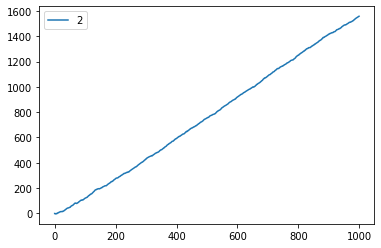

In [91]:
env = gym.make("BanditTenArmedGaussian-v0")
env.reset()
actions = env.action_space

class UpperConfidenceBoundBandit():
  values = []
  taken = []
  confidence = []
  c = None
  num_arms = None
  t = 1

  def __init__(self, num_arms = 10, c = 2):
    self.values = [0]*num_arms
    self.taken = [0]*num_arms
    self.num_arms = num_arms
    self.confidence = [0]*num_arms
    self.c = c

    for a in range(num_arms):
      self.compute_confidence(a)

  def compute_confidence(self, a):
    qt = self.values[a] 
    nt = self.taken[a]
    if nt <= 0:
      conf = float('inf')
    else:
      conf = qt + self.c * np.sqrt(np.log(self.t)/nt)
    self.confidence[a] = conf
  

  # Instead of picking randomly, we're going to compute confidence based on how many times the action has been tried
  def sample(self):
    a = np.argmax(self.confidence)
    self.taken[a] += 1
    self.t += 1
    return a

  def update(self, action, obs, reward, done, info):
    n = self.taken[action]
    qn = self.values[action]
    rn = reward
    self.values[action] = qn+(1/n)*(rn - qn)
    self.compute_confidence(action)


def plot_rewards(bandit, sum_rewards, plot_data):
  fig, ax = plt.subplots()  # Create a figure containing a single axes.
  print(f"Total rewards: {sum_rewards}")
  print(bandit.taken)
  print(bandit.values)
  print(bandit.confidence)
  ax.plot(plot_data[0], plot_data[1],label=round(bandit.c,1))
  plt.legend(loc='best')
  plt.show()


num_arms = 10
num_steps = 1000

def run_bandit():
  bandit = UpperConfidenceBoundBandit()
  sum_rewards = 0
  plot_data = ([], [])
  for step in range(num_steps):
      action = bandit.sample()
      obs, reward, done, info = env.step(action)
      bandit.update(action, obs, reward, done, info)
      sum_rewards += reward
      plot_data[0].append(step)
      plot_data[1].append(sum_rewards)
  plot_rewards(bandit, sum_rewards, plot_data)
  
run_bandit()
env.close()

Result:

On average performs better than epsilon 0.1. More difficult to implement in reality. 